<a href="https://colab.research.google.com/github/pzaborowski/GEE-training/blob/master/sandbox_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import ee;

#ee.Authenticate();
ee.Initialize();

In [5]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import rpy2
#@title Manage the required R packages
import rpy2.robjects as robjects
# import rpy2's package module
import rpy2.robjects.packages as rpackages
# import R's utility package
utils = rpackages.importr('utils')
# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ('ggplot2', 'hexbin', 'lubridate') # etc
# R vector of strings
from rpy2.robjects.vectors import StrVector
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
 utils.install_packages(StrVector(names_to_install))
r = robjects.r
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
SILO = ee.ImageCollection("projects/eo-datascience-public/assets/silo_daily")
geometry = ee.Geometry.MultiPolygon(
 [[[[143.80552717710506, -38.00635783136687],
 [143.80552717710506, -38.23971307743717],
 [144.16807600523006, -38.23971307743717],
 [144.16807600523006, -38.00635783136687]]],
 [[[145.81602522398006, -37.763572829223904],
 [145.81602522398006, -38.05827899594066],
 [146.23899885679256, -38.05827899594066],
 [146.23899885679256, -37.763572829223904]]],
 [[[144.68992659116756, -37.73316844770863],
 [144.68992659116756, -38.00635783136687],
 [145.21177717710506, -38.00635783136687],
 [145.21177717710506, -37.73316844770863]]]], None, False)
fcROIs = ee.FeatureCollection(geometry.geometries().map(lambda g: ee.Feature(ee.Geometry(g))))


In [50]:
data = SILO.filterDate('2019-01-01','2019-12-31').select('daily_rain')\
  .toBands()\
  .reduceRegions(fcROIs,ee.Reducer.mean(),5000);
mtemp_list = SILO.filterDate('2019-01-01','2019-12-31').select('max_temp')\
  .toBands()\
  .reduceRegions(fcROIs,ee.Reducer.mean(),5000);
local = data.getInfo();

In [52]:
mtemp_info = mtemp_list.getInfo();
mtemp_info

{'columns': {'2019_100_max_temp': 'Float',
  '2019_101_max_temp': 'Float',
  '2019_102_max_temp': 'Float',
  '2019_103_max_temp': 'Float',
  '2019_104_max_temp': 'Float',
  '2019_105_max_temp': 'Float',
  '2019_106_max_temp': 'Float',
  '2019_107_max_temp': 'Float',
  '2019_108_max_temp': 'Float',
  '2019_109_max_temp': 'Float',
  '2019_10_max_temp': 'Float',
  '2019_110_max_temp': 'Float',
  '2019_111_max_temp': 'Float',
  '2019_112_max_temp': 'Float',
  '2019_113_max_temp': 'Float',
  '2019_114_max_temp': 'Float',
  '2019_115_max_temp': 'Float',
  '2019_116_max_temp': 'Float',
  '2019_117_max_temp': 'Float',
  '2019_118_max_temp': 'Float',
  '2019_119_max_temp': 'Float',
  '2019_11_max_temp': 'Float',
  '2019_120_max_temp': 'Float',
  '2019_121_max_temp': 'Float',
  '2019_122_max_temp': 'Float',
  '2019_123_max_temp': 'Float',
  '2019_124_max_temp': 'Float',
  '2019_125_max_temp': 'Float',
  '2019_126_max_temp': 'Float',
  '2019_127_max_temp': 'Float',
  '2019_128_max_temp': 'Float',

In [42]:
from datetime import datetime;
process_date = lambda x: datetime.strptime(x,'%Y_%j_daily_rain').strftime('%Y-%m-%d')

def get_series(ind):
  dats = sorted(local['features'][ind]['properties'].keys());
  vals = list(local['features'][ind]['properties'].values());

  from datetime import datetime
  j = sorted(list(map(process_date,dats)))
  d = np.array(j);
  v = np.array(vals)
  return d, v

stuff = list(map(get_series,(0,1,2)))

In [43]:
num = len(stuff)
dates = np.array([a[0] for a in stuff])
rain = np.array([a[1] for a in stuff])

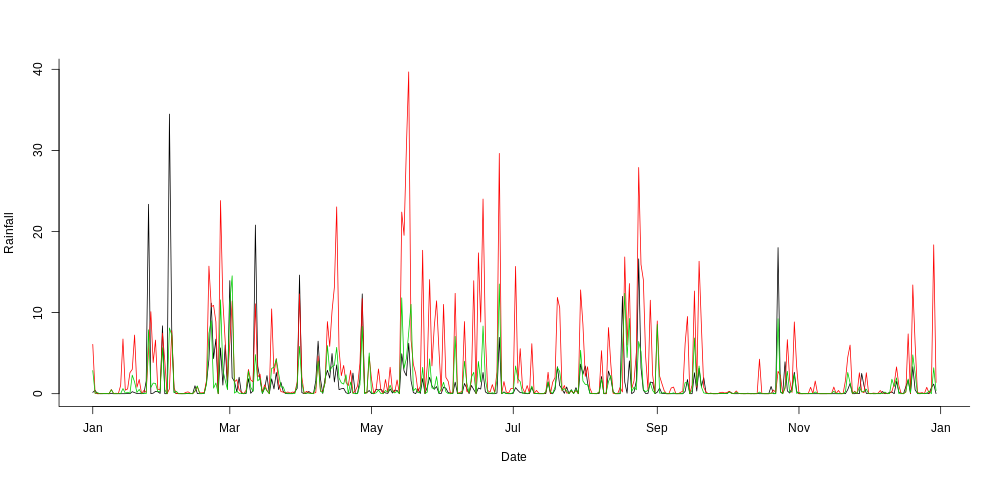

In [44]:
%%R -i dates,rain,num -w 1000
d <- as.Date(dates)
d <- matrix(dates, ncol=num, byrow=T)
r <- matrix(rain, ncol=num, byrow=T)


plot(as.Date(d[,1]),r[,1], type='n', xlim=range(as.Date(d)), ylim=range(r), bty='l', xlab='Date', ylab='Rainfall')

for(i in seq(1,num)){
    lines(as.Date(d[,i]),r[,i], col=i)
}